In [360]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [361]:
arquivos= ['x-','x+','y-','y+','z-','z+']
todas_leituras = [pd.read_csv(n,sep='\s+',header=None, dtype=np.float64).iloc[2:-2 , :] for n in ['dados-imu/x-.csv','dados-imu/x+.csv','dados-imu/y-.csv','dados-imu/y+.csv','dados-imu/z-.csv','dados-imu/z+.csv']]

In [362]:
todas_leituras_combinadas = pd.concat(todas_leituras)

In [363]:
def costfunc1(x, data, scale):
    v = x[:-1]
    g = x[-1]
    R = np.linalg.norm(v+data,axis=1)
    F = sum((scale*R-g)**2)

    return F


def grad_costfunc1(x, data, scale):
    v = x[:-1]
    g = x[-1]
    R = np.linalg.norm(v+data,axis=1)
    R_aux = np.array([ [n] for n in R])
    dR = (v+data)/R_aux
    dF_vx = sum(2*scale*dR[0]*(scale*R-g))
    dF_vy = sum(2*scale*dR[1]*(scale*R-g))
    dF_vz = sum(2*scale*dR[2]*(scale*R-g))
    dF_g  = sum(-2*(scale*R-g))
    return [dF_vx,dF_vy,dF_vz,dF_g]
    

In [364]:
scale = 0.000598
res1 = minimize(costfunc1 , [0.0 , 0.0 , 0.0 , 9.8] , (todas_leituras_combinadas, scale) , jac=grad_costfunc1, method = 'BFGS')
print(res1)
print(res1.x)

      fun: 111.59919715547883
 hess_inv: array([[ 2.24181813e+02,  5.53259495e+00,  4.94404145e-01,
        -1.85456191e-04],
       [ 5.53259495e+00,  2.29694940e+02,  7.36017906e-01,
        -2.88258358e-04],
       [ 4.94404145e-01,  7.36017906e-01,  2.31397054e+02,
        -2.99872832e-04],
       [-1.85456191e-04, -2.88258358e-04, -2.99872832e-04,
         2.80026107e-05]])
      jac: array([ 5.96134135e-09, -3.50918046e-09,  4.43203366e-10,  8.32743336e-07])
  message: 'Optimization terminated successfully.'
     nfev: 35
      nit: 27
     njev: 35
   status: 0
  success: True
        x: array([-875.71310266,   79.44263289, -603.07464153,    9.79276866])
[-875.71310266   79.44263289 -603.07464153    9.79276866]


(array([1.000e+01, 1.130e+02, 5.980e+02, 1.589e+03, 2.491e+03, 2.325e+03,
        2.260e+03, 1.532e+03, 7.580e+02, 1.840e+02, 3.600e+01, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 8.000e+00,
        3.200e+01, 1.180e+02, 3.450e+02, 7.640e+02, 1.182e+03, 1.317e+03,
        1.172e+03, 6.360e+02, 2.490e+02, 9.600e+01, 2.500e+01, 4.000e+00]),
 array([9.68674967, 9.69596889, 9.70518811, 9.71440733, 9.72362655,
        9.73284577, 9.74206499, 9.75128421, 9.76050343, 9.76972265,
        9.77894187, 9.78816109, 9.79738031, 9.80659953, 9.81581875,
        9.82503797, 9.83425719, 9.84347641, 9.85269563, 9.86191485,
        9.87113407, 9.88035329, 9.88957251, 9.89879173, 9.90801095,
        9.91723017, 9.92644939, 9.93566861, 9.94488783, 9.95410705,
        9.96332627]),
 <BarContainer object of 30 artists>)

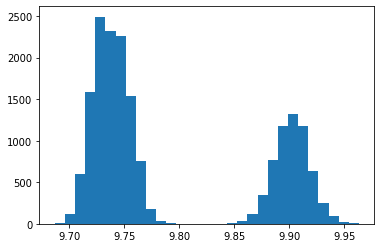

In [365]:
def calc_accel1(medida, parametros, scale):
    rx, ry, rz = medida
    rx += parametros[0]
    ry += parametros[1]
    rz += parametros[2]
    return scale*np.sqrt(rx*rx + ry*ry + rz*rz)

medidas_g = [calc_accel1(m,res1.x, scale) for m in todas_leituras_combinadas.values.tolist()]

plt.hist(medidas_g, bins =30)

In [366]:
medidas_g_separadas = [[calc_accel1(m, res1.x ,scale) for m in leitura.values.tolist()] for leitura in todas_leituras]

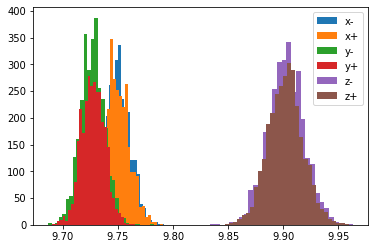

In [367]:
fig, ax = plt.subplots()
ax.hist(medidas_g_separadas[0], bins =30, label = arquivos[0])
ax.hist(medidas_g_separadas[1], bins =30, label = arquivos[1])
ax.hist(medidas_g_separadas[2], bins =30, label = arquivos[2])
ax.hist(medidas_g_separadas[3], bins =30, label = arquivos[3])
ax.hist(medidas_g_separadas[4], bins =30, label = arquivos[4])
ax.hist(medidas_g_separadas[5], bins =30, label = arquivos[5])
ax.legend()

In [368]:
def costfunc2 (x, data, g, scale):
    v = x[:3]
    s = x[3:]
    R = np.linalg.norm(s*(v+data),axis=1)
    F = sum((scale*R-g)**2)
    return F
    
def grad_costfunc2 (x, data, g, scale):
    v = x[:3]
    s = x[3:]
    R = np.linalg.norm(s*(v+data),axis=1)
    R_aux = np.array([ [n] for n in R])
    dR_dv = (s**2)*(v+data)/R_aux
    dR_ds = ((s)*(v+data)**2)/R_aux
    dF_vx = sum(2*scale*dR_dv[0]*(scale*R-g))
    dF_vy = sum(2*scale*dR_dv[1]*(scale*R-g))
    dF_vz = sum(2*scale*dR_dv[2]*(scale*R-g))
    dF_sx = sum(2*scale*dR_ds[0]*(scale*R-g))
    dF_sy = sum(2*scale*dR_ds[1]*(scale*R-g))
    dF_sz = sum(2*scale*dR_ds[2]*(scale*R-g))
    return [dF_vx,dF_vy,dF_vz,dF_sx,dF_sy,dF_sz]



In [369]:
g = 9.786366
res2 = minimize(costfunc2, [res1.x[0],res1.x[1],res1.x[2],1.0,1.0,1.0], (todas_leituras_combinadas, g, scale), jac=grad_costfunc2, method = 'BFGS')
print(res2)

      fun: 2.9875589882973235
 hess_inv: array([[ 1.91193952e+02, -9.50721871e+00,  2.13244587e+01,
        -1.01037626e-05, -2.78534707e-06,  2.32762760e-05],
       [-9.50721871e+00,  2.28513651e+02,  4.34581799e+00,
         7.57251806e-05,  4.72917877e-05, -2.65374350e-05],
       [ 2.13244587e+01,  4.34581799e+00,  2.28375069e+02,
         1.04694996e-04,  1.08029934e-04, -1.78693278e-04],
       [-1.01037626e-05,  7.57251806e-05,  1.04694996e-04,
         8.83476556e-07, -1.29847419e-09,  2.37969199e-09],
       [-2.78534707e-06,  4.72917877e-05,  1.08029934e-04,
        -1.29847419e-09,  8.86115037e-07,  4.09262544e-09],
       [ 2.32762760e-05, -2.65374350e-05, -1.78693278e-04,
         2.37969199e-09,  4.09262544e-09,  8.49149250e-07]])
      jac: array([-3.21742246e-09, -6.95849603e-10,  1.54509521e-09, -5.50138127e-07,
       -8.70885594e-07,  1.78927475e-06])
  message: 'Optimization terminated successfully.'
     nfev: 47
      nit: 34
     njev: 47
   status: 0
  success:

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   4.,   2.,   3.,   3.,   3.,   2.,   6.,   5.,  11.,
         13.,  18.,  15.,  22.,  24.,  24.,  36.,  51.,  50.,  74.,  87.,
         91., 129., 146., 154., 188., 220., 280., 286., 331., 387., 379.,
        483., 510., 577., 653., 673., 758., 820., 732., 715., 784., 700.,
        717., 684., 631., 598., 539., 522., 521., 442., 393., 352., 326.,
        251., 224., 215., 165., 139., 131.,  95.,  65.,  68.,  57.,  41.,
         41.,  30.,  19.,  31.,  20.,  18.,  10.,   9.,  12.,  11.,   2.,
          2.,   2.,   3.,   2.,   2.,   2.,   0.,   1.,   0.,   2.,   0.,
          1.]),
 array([9.71849566, 9.71977477, 9.72105389, 9.722333  , 9.72361211,
        9.72489122, 9.72617033, 9.72744944, 9.72872855, 9.73000766,
        9.73128677, 9.73256588, 9.73384499, 9.7351241 , 9.73640321,
        9.73768232, 9.73896143, 9.74024054, 9.74151965, 9.74279876,
        9.74407787, 9.74535699, 9.7466361 , 9.

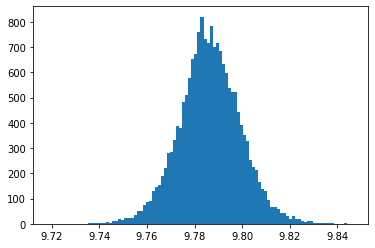

In [370]:
def calc_accel2(medida, parametros, scale):
    rx, ry, rz = medida
    rx = parametros[3]*(rx+parametros[0])
    ry = parametros[4]*(ry+parametros[1])
    rz = parametros[5]*(rz+parametros[2])
    return scale*np.sqrt(rx*rx+ry*ry+rz*rz)

medidas_g2 = [calc_accel2(m,res2.x, scale) for m in todas_leituras_combinadas.values.tolist()]

plt.hist(medidas_g2, bins=100)

In [371]:
medidas_g_separadas2 = [[calc_accel2(m, res2.x ,scale) for m in leitura.values.tolist()] for leitura in todas_leituras]

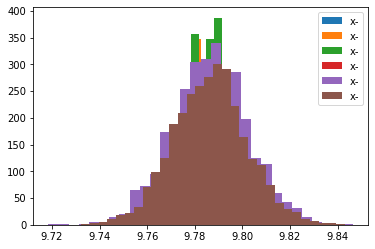

In [372]:
fig, ax = plt.subplots()
ax.hist(medidas_g_separadas2[0], bins =30, label = arquivos)
ax.hist(medidas_g_separadas2[1], bins =30, label = arquivos)
ax.hist(medidas_g_separadas2[2], bins =30, label = arquivos)
ax.hist(medidas_g_separadas2[3], bins =30, label = arquivos)
ax.hist(medidas_g_separadas2[4], bins =30, label = arquivos)
ax.hist(medidas_g_separadas2[5], bins =30, label = arquivos)
ax.legend()

# Perguntas
1. Qual o valor do desvio padrão das acelerações em medidas g2:

In [374]:
desvpad=np.std(medidas_g2)
desvpad

0.012937154206142321

2. Qual o valor do desvio relativo, ou seja a razão entre o desvio padrão e a
média de medidas g2?


In [376]:
media=np.mean(medidas_g2)
desvpad/media

0.0013219592251918367